In [1]:
%run ~/.python/init.ipynb

In [2]:
import torch
from torchvision import transforms
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
import PIL

In [7]:
root = Path('/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/train_test_splits/carla-no-traffic/')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
df = pd.read_csv(root/"video_test.csv", index_col=0)

In [58]:
class CARLADataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = torch.load(root).numpy()
        self.target = np.load(root
                              .replace("carla-no-traffic/video","carla-no-traffic/coords")
                              .replace(".pt",'.npy'))

    def __getitem__(self, idx):
        # load images and masks         
        img = self.imgs[idx]
        target = self.target[idx]

        # use x,y only
        target = target[[0,1]]
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)
    

In [59]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    fig, ax = plt.subplots(figsize=(12,24))
    ax.imshow(inp, interpolation='nearest')
    plt.tight_layout()
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    

In [60]:
def load_model(path):
    model = torchvision.models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2) # added dimension for classification

    model = model.to(device)
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [83]:
def make_data(path):
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
    )

    print(path)
    return torch.utils.data.DataLoader(
        CARLADataset(path, data_transform),
        batch_size=20,
        shuffle=False,
        num_workers=2) 

In [78]:
model = load_model('./models/model.pth')

In [ ]:
def predict_trajectory(dataloader):
    inputs = next(iter(dataloader))
    inputs = inputs.to(device)
    outputs = model(inputs)
    return outputs.cpu().detach().numpy()
    

In [96]:
def predict_trajectory(path):
    dataset = make_data(path)
    outputs, labels = [], []
    for inputs, label in dataset:
        inputs = inputs.to(device)
        out = model(inputs).cpu().detach().numpy()

        outputs.append(out)
        labels.append(label.numpy())

    outputs = np.vstack(outputs)
    labels = np.vstack(labels)
    return outputs, labels

In [110]:
def plot_trajectory(out, gt, k):
    fig, ax = plt.subplots(1, 1, dpi=150, figsize=(4, 3))

    x, y = out[:, 0], out[:,1]
    
    ax = sns.lineplot(x=out[:, 0],
                      y=out[:,1],
                      sort=False,
                      lw=1,
                      ax=ax,
                      label="regressor",
                      legend=False,
                     )

    ax = sns.lineplot(x=gt[:, 0],
                      y=gt[:,1],
                      sort=False,
                      lw=1,
                      ax=ax,
                      label="ground_truth",
                      legend=False,
                     )
    
    xlim = (-10, 400)
    ylim = (-10, 350)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles,
               labels,
               ncol=5,
               loc='lower center',
               bbox_to_anchor=(0.5, -0.1),
               bbox_transform=plt.gcf().transFigure
              )
    plt.show()

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_425.pt


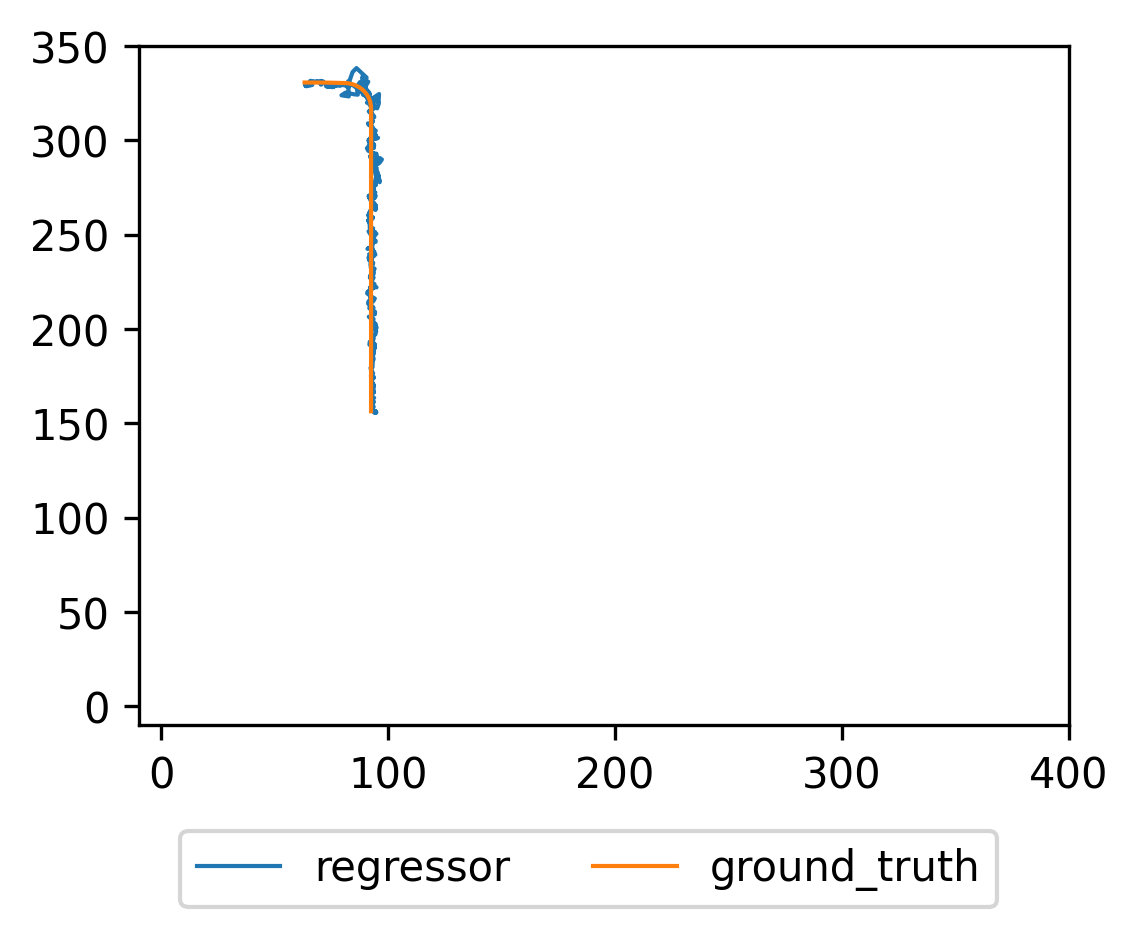

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_426.pt


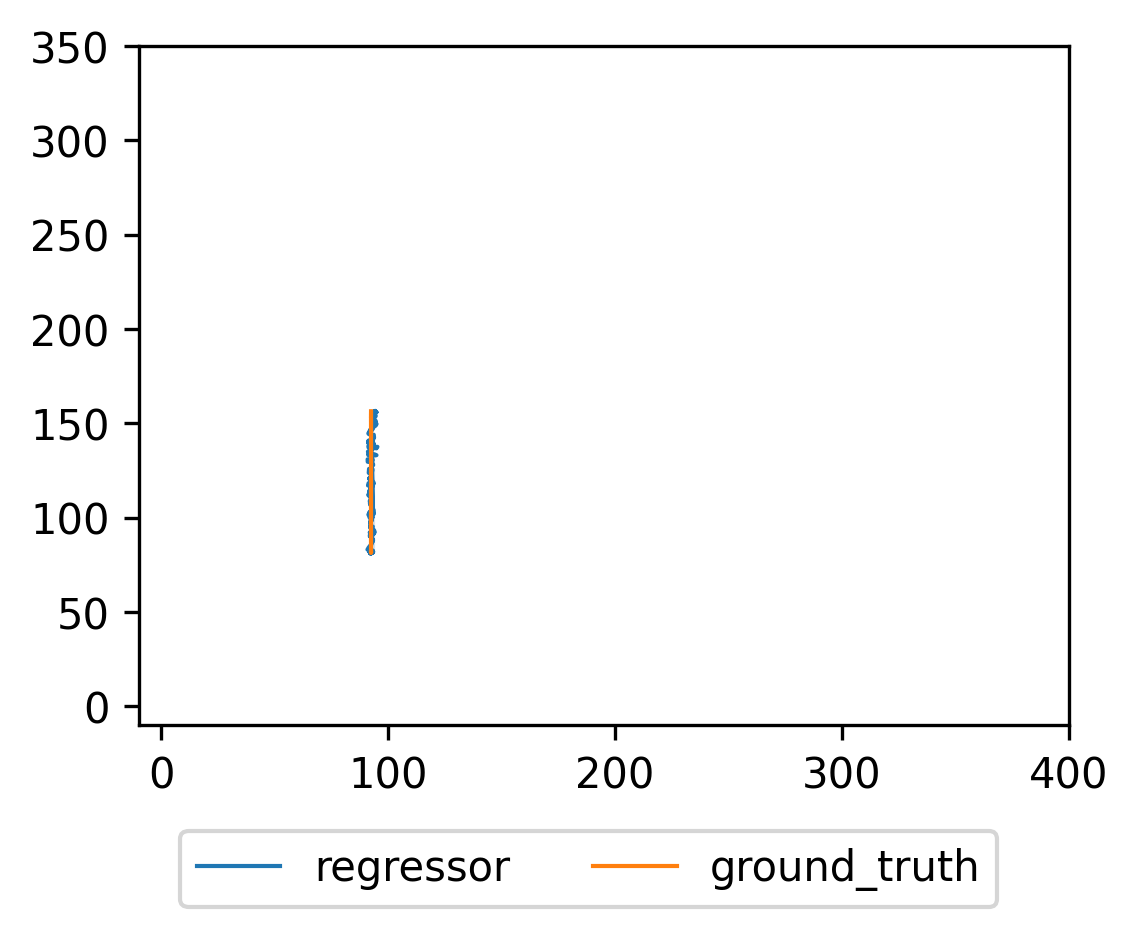

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_427.pt


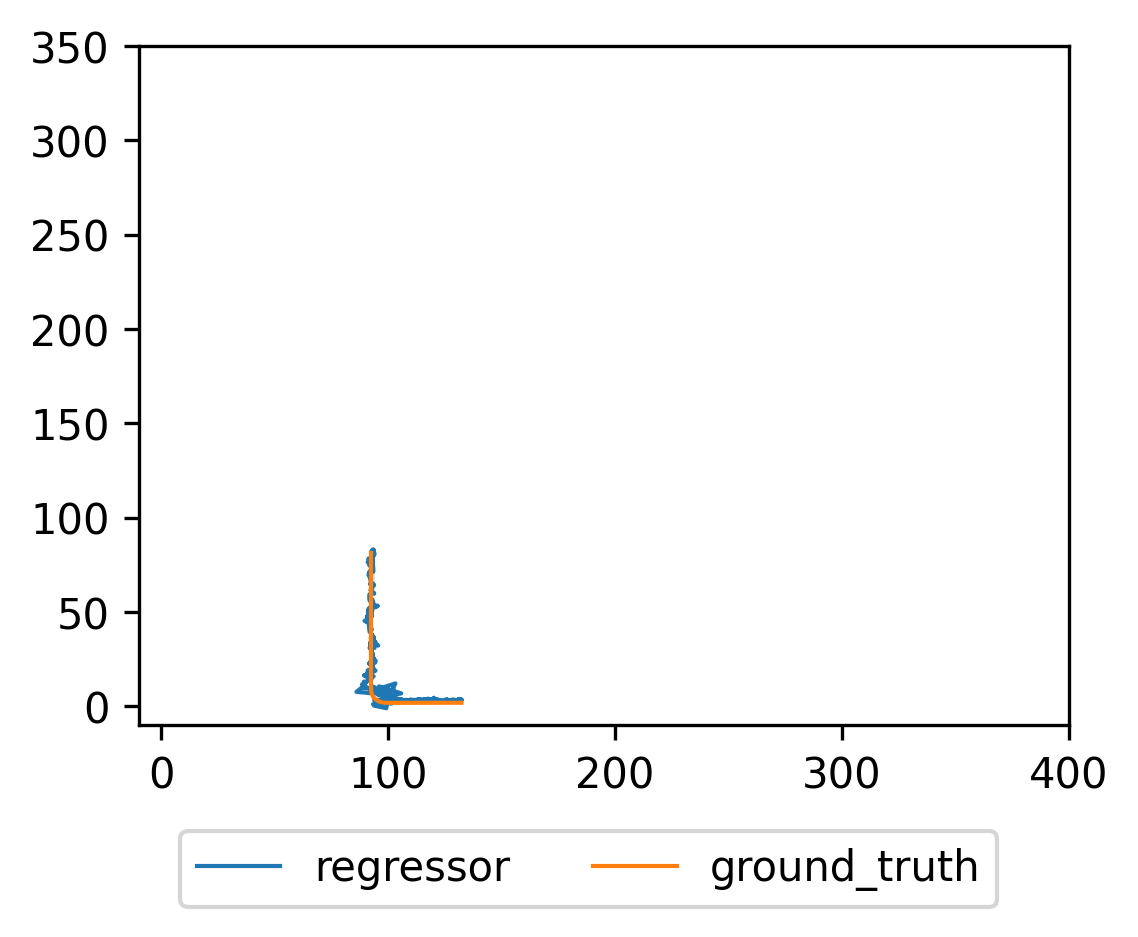

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_428.pt


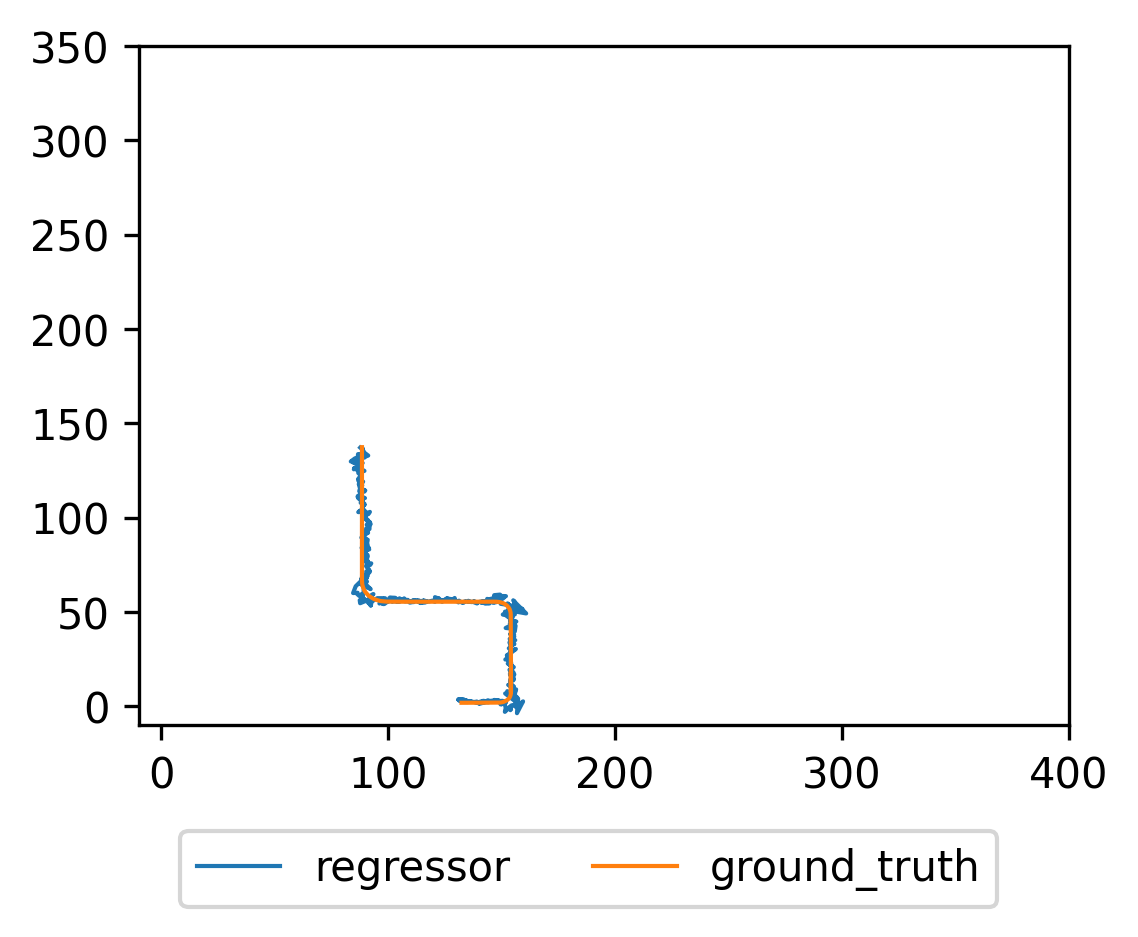

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_429.pt


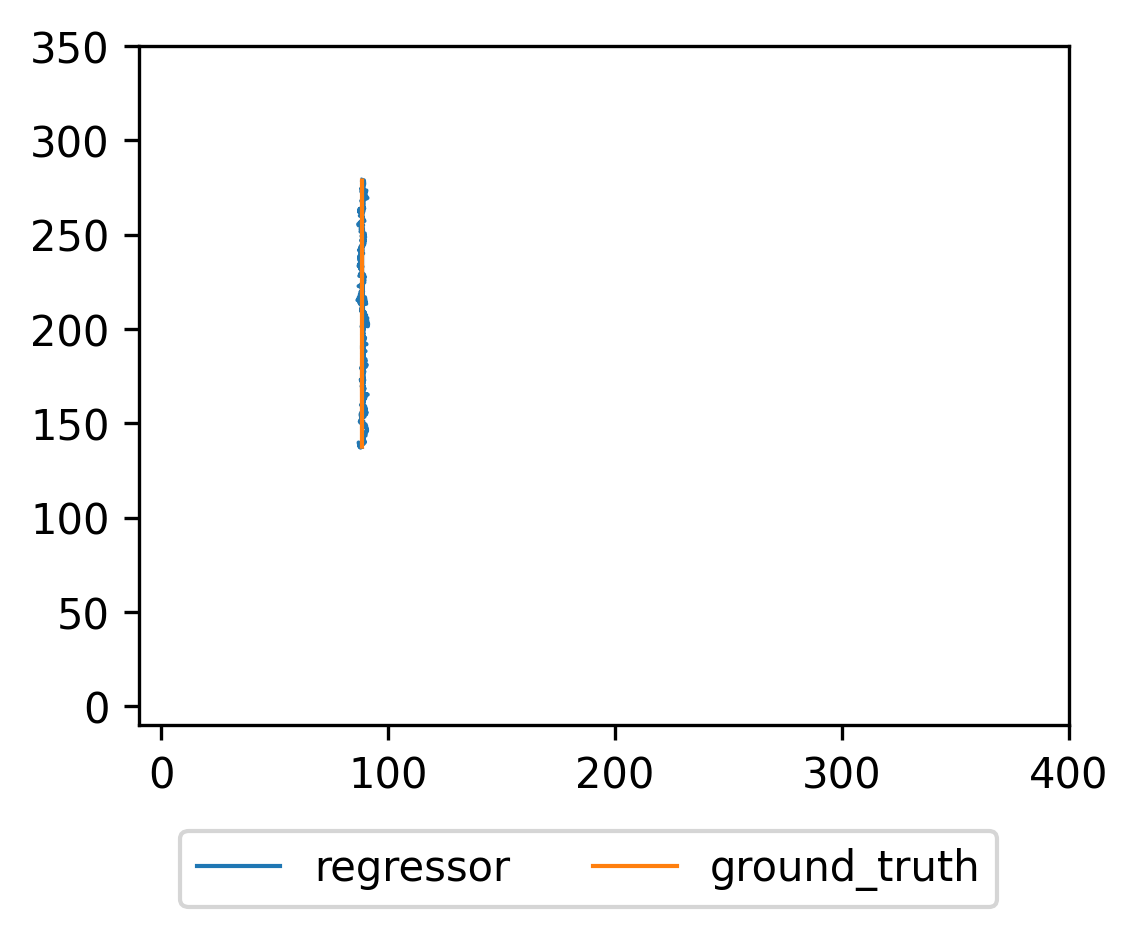

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_430.pt


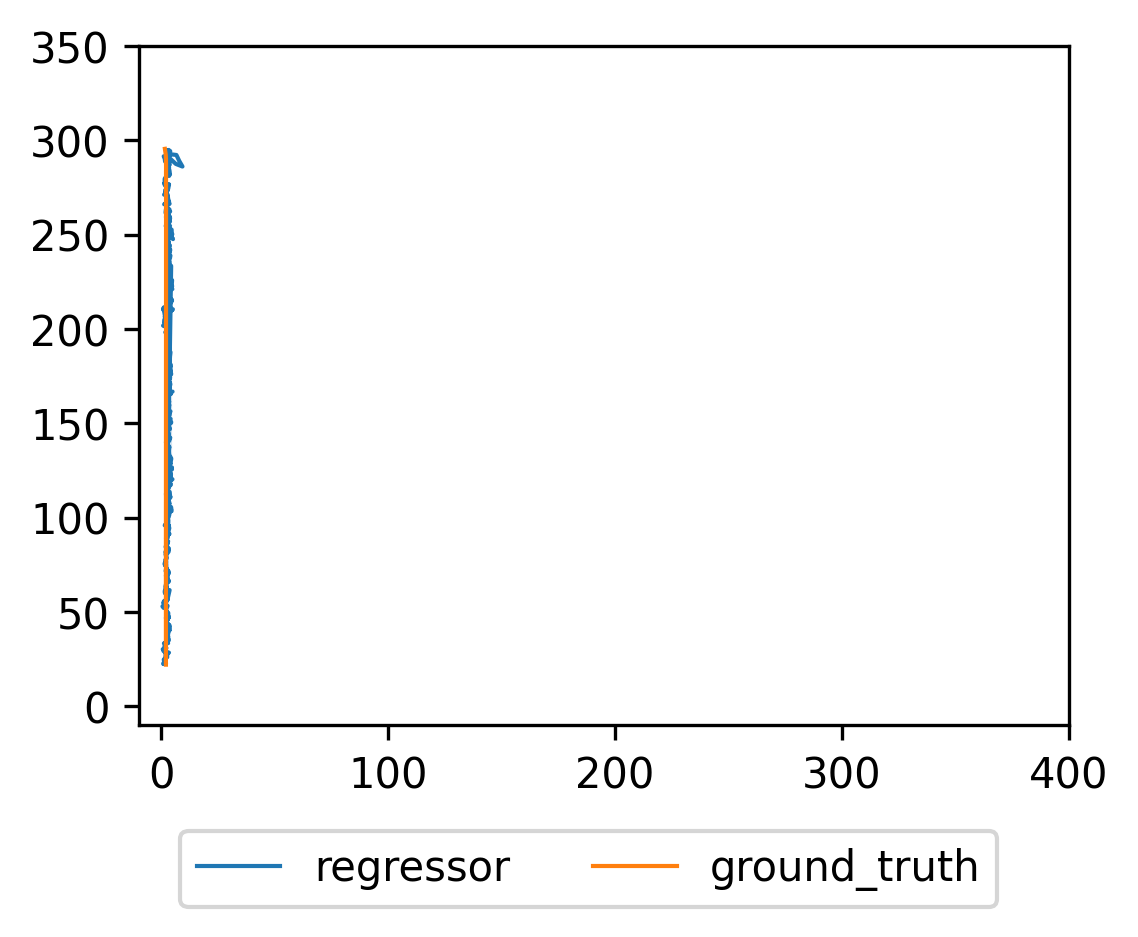

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_431.pt


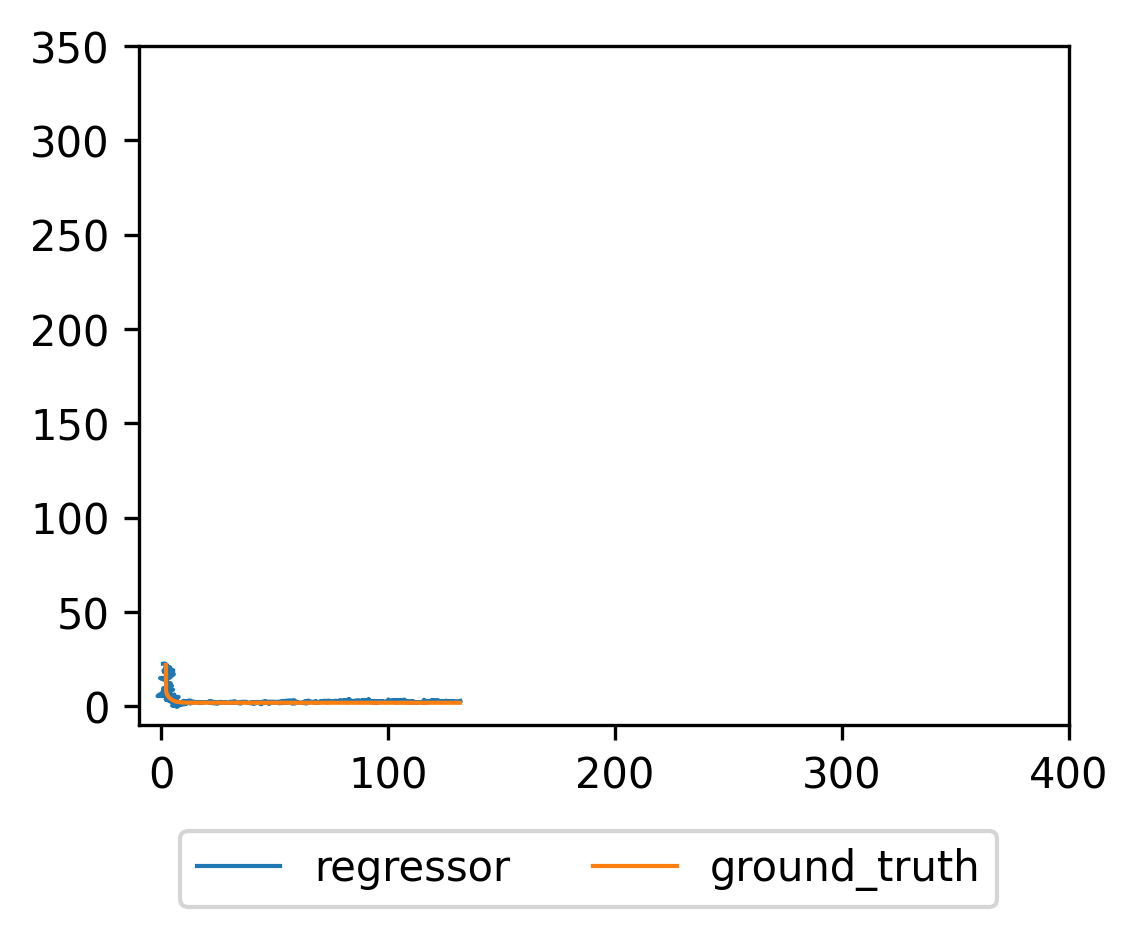

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_432.pt


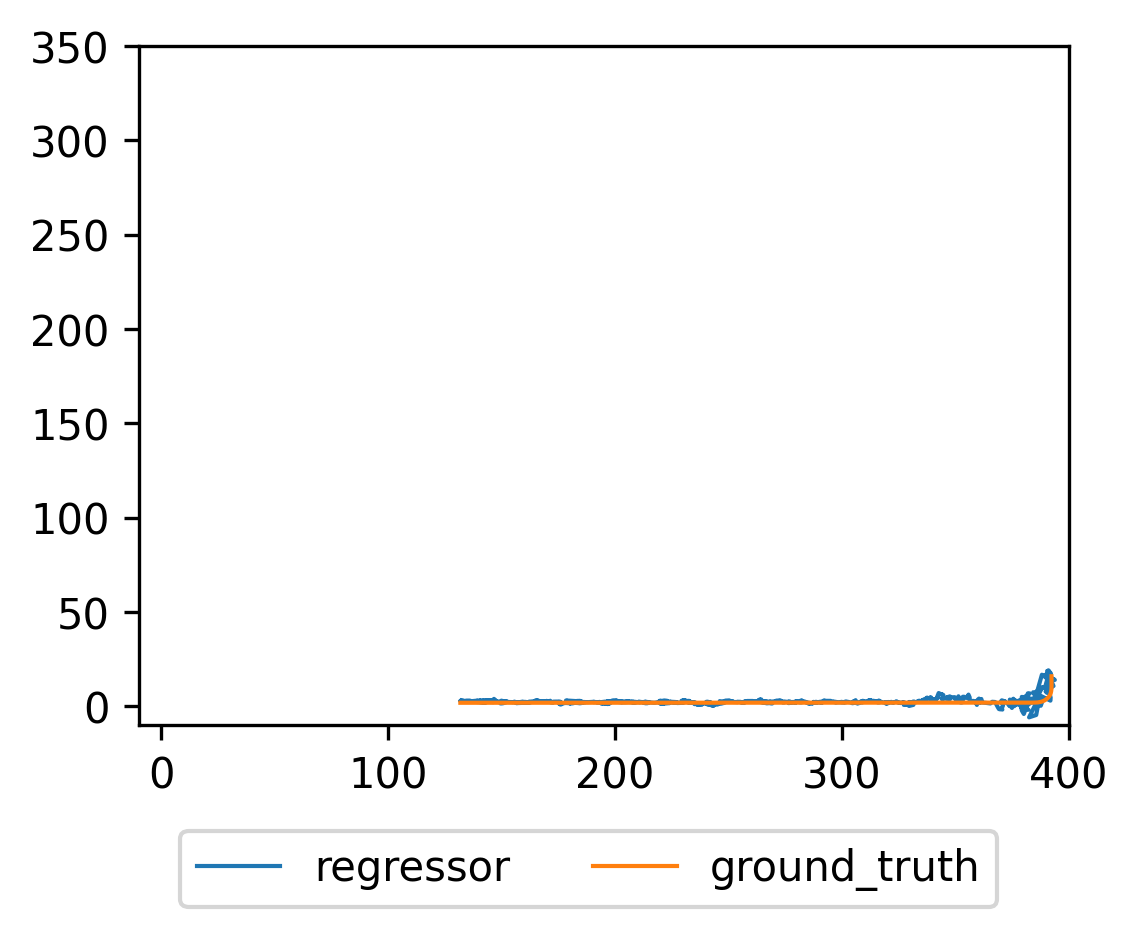

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_433.pt


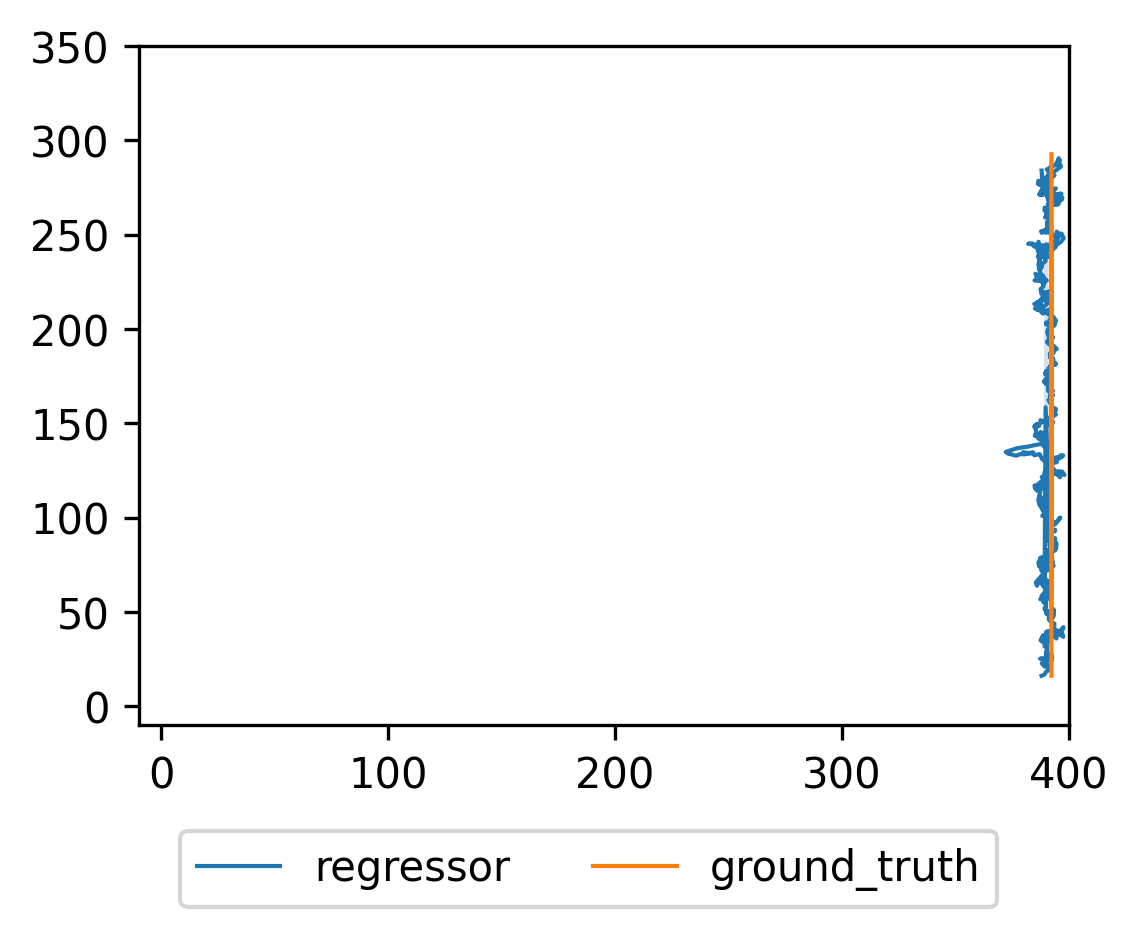

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_434.pt


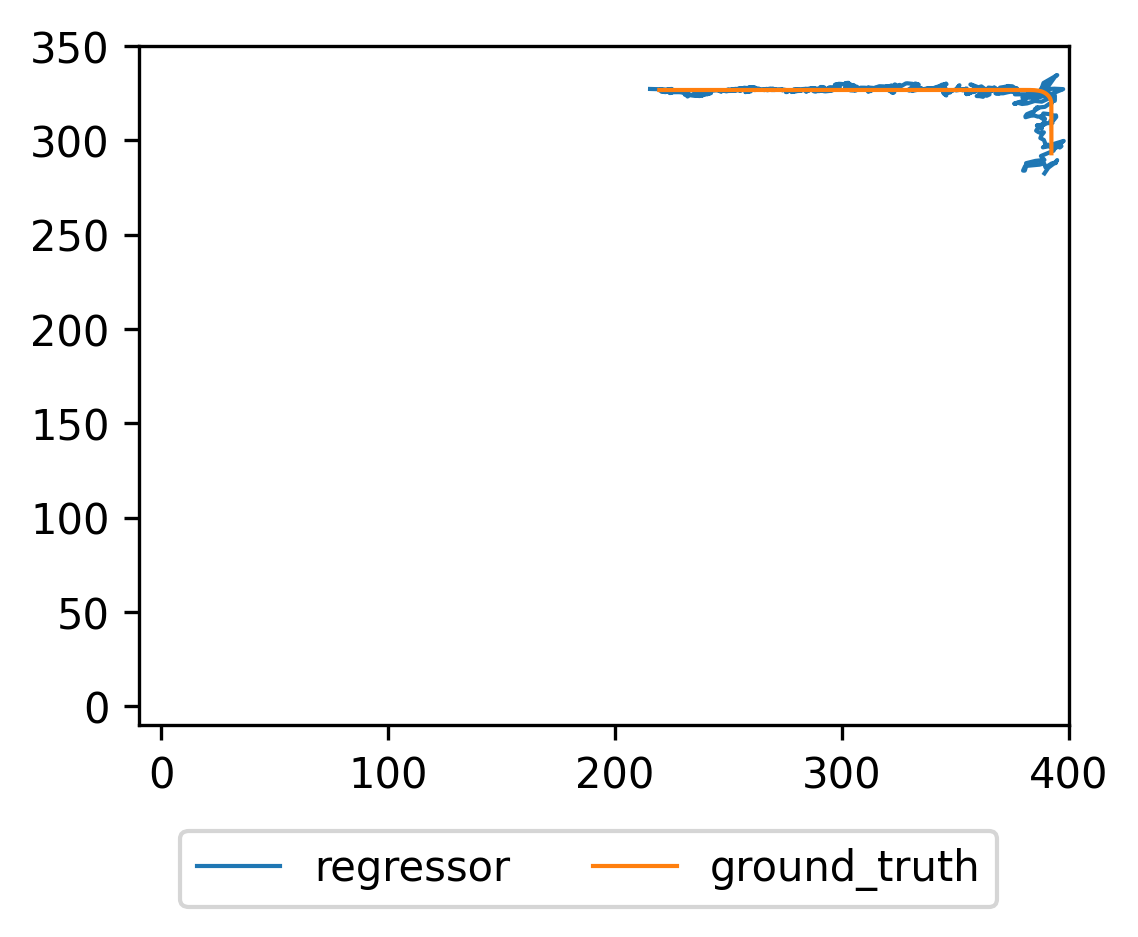

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_435.pt


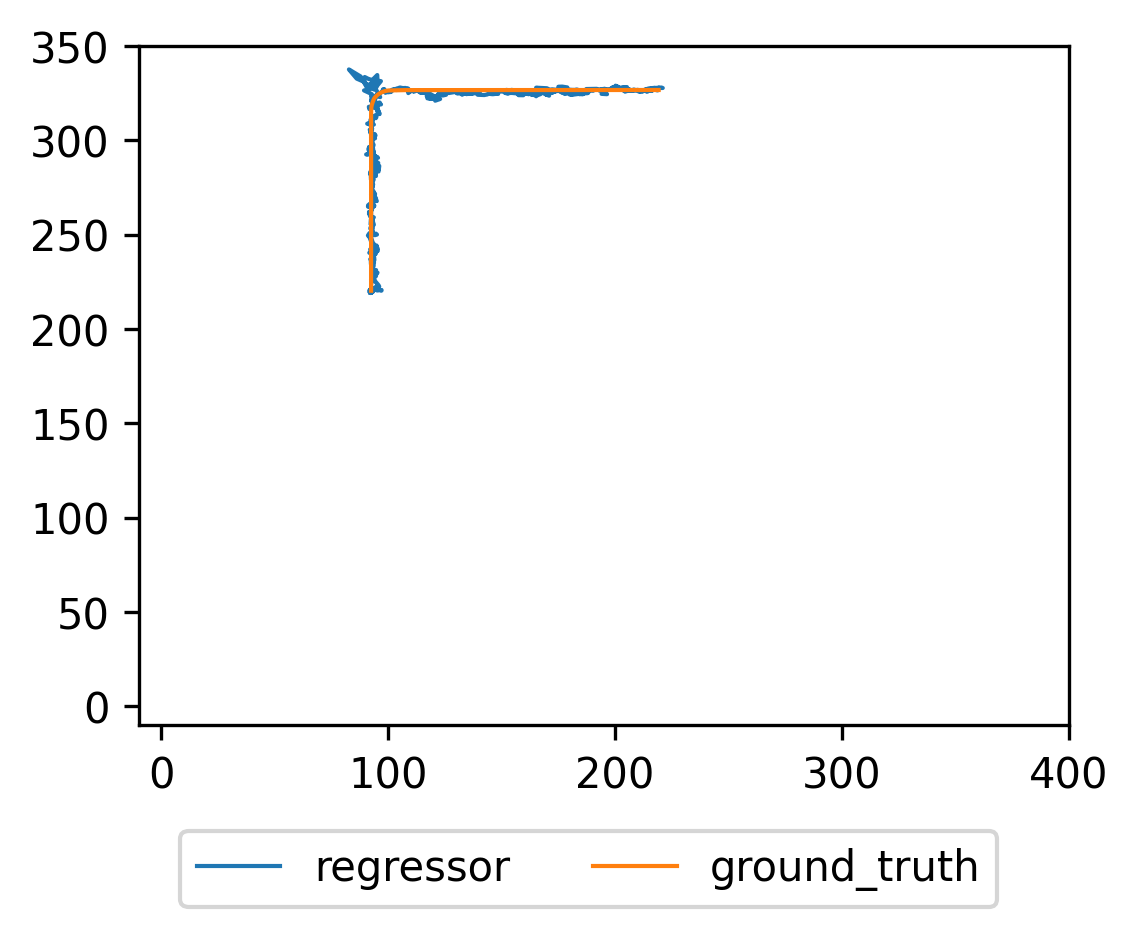

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_436.pt


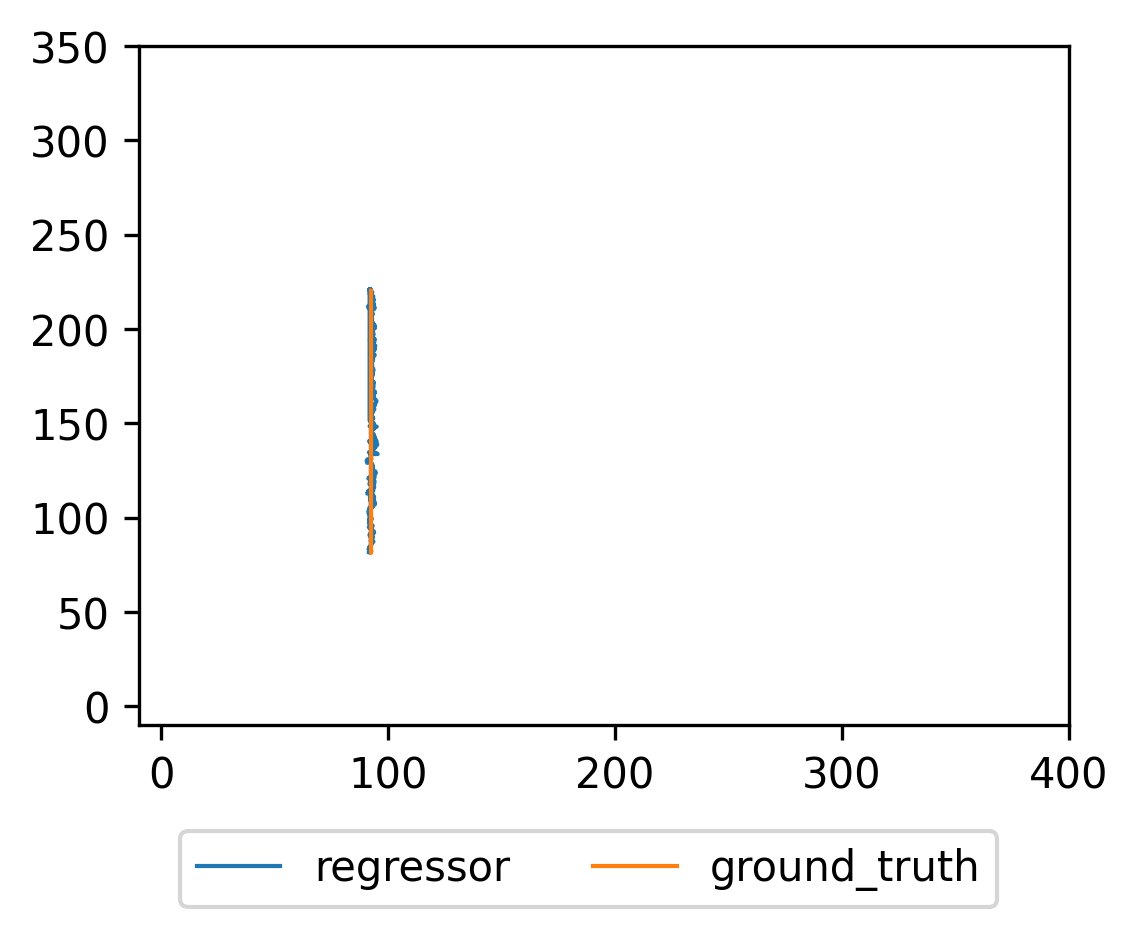

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_440.pt


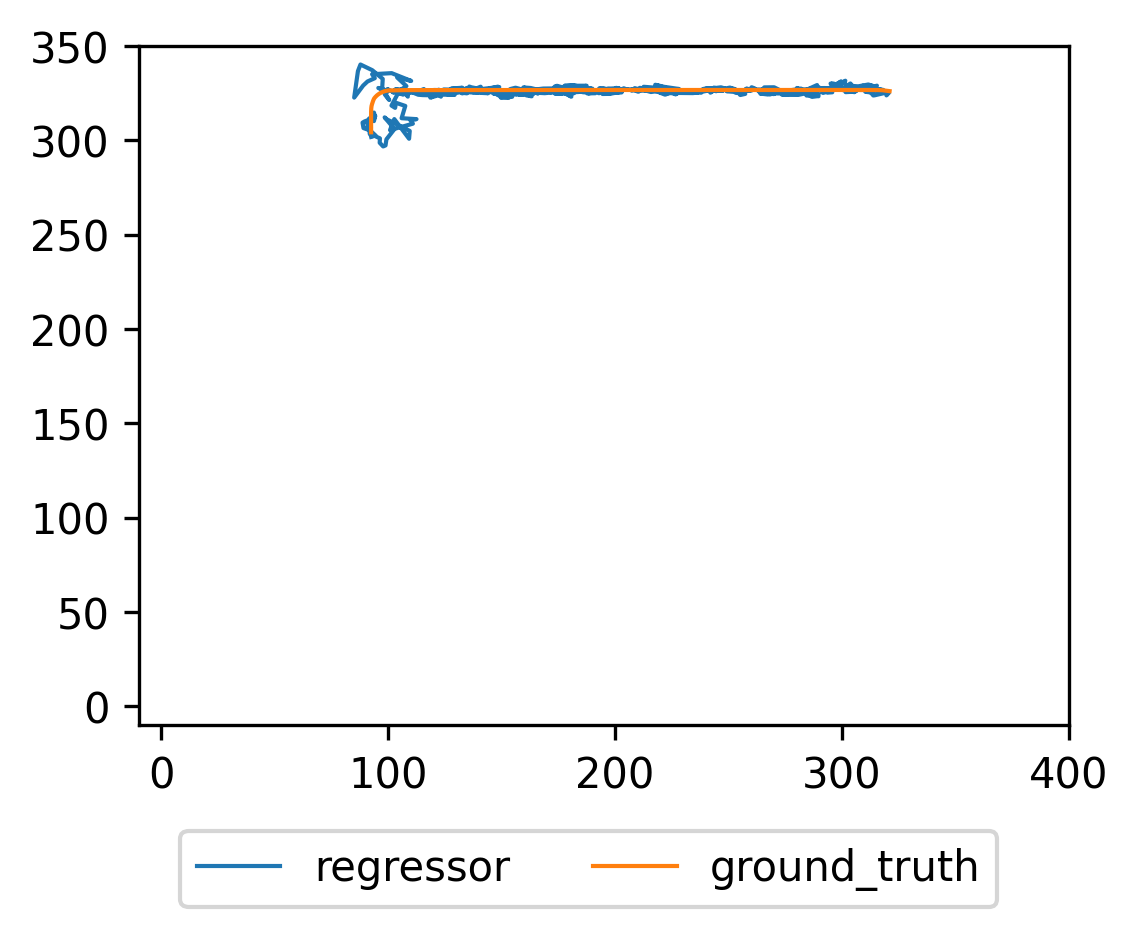

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_441.pt


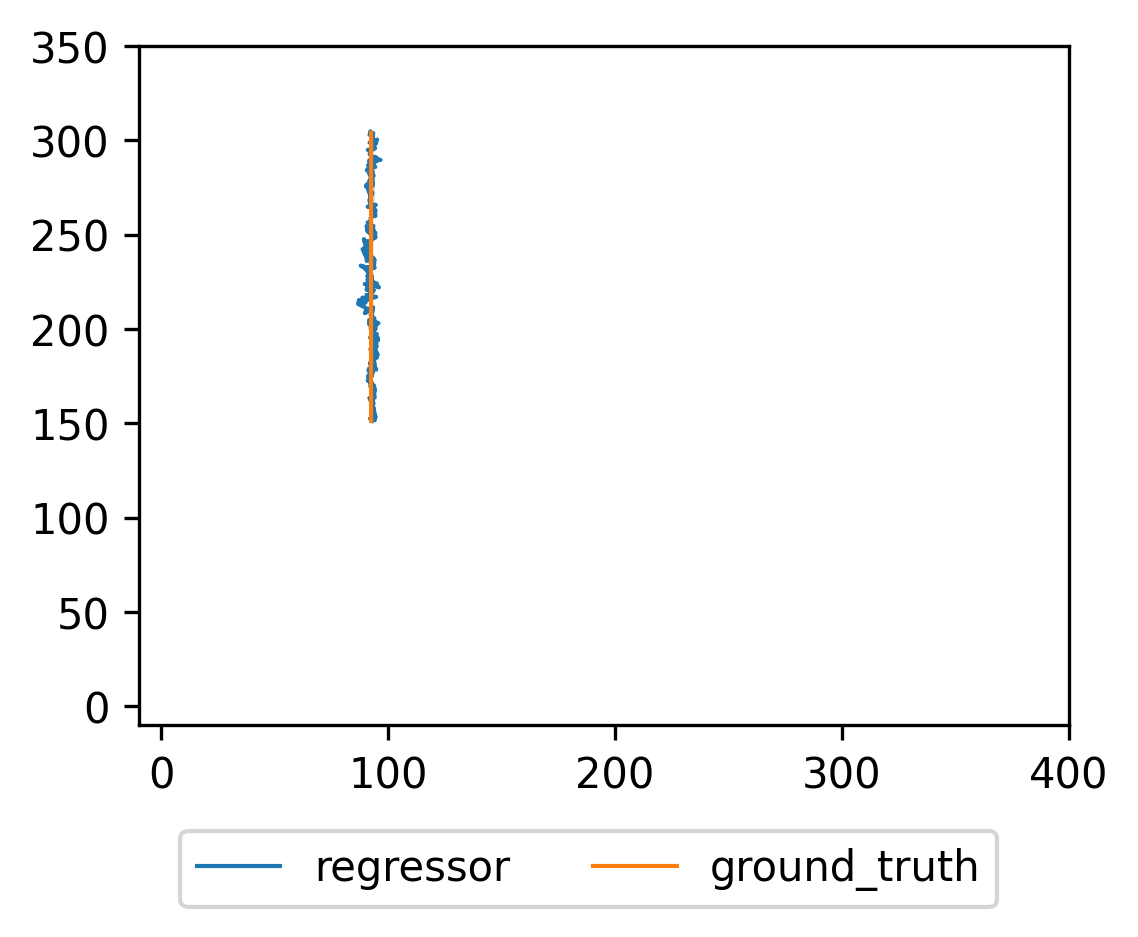

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_442.pt


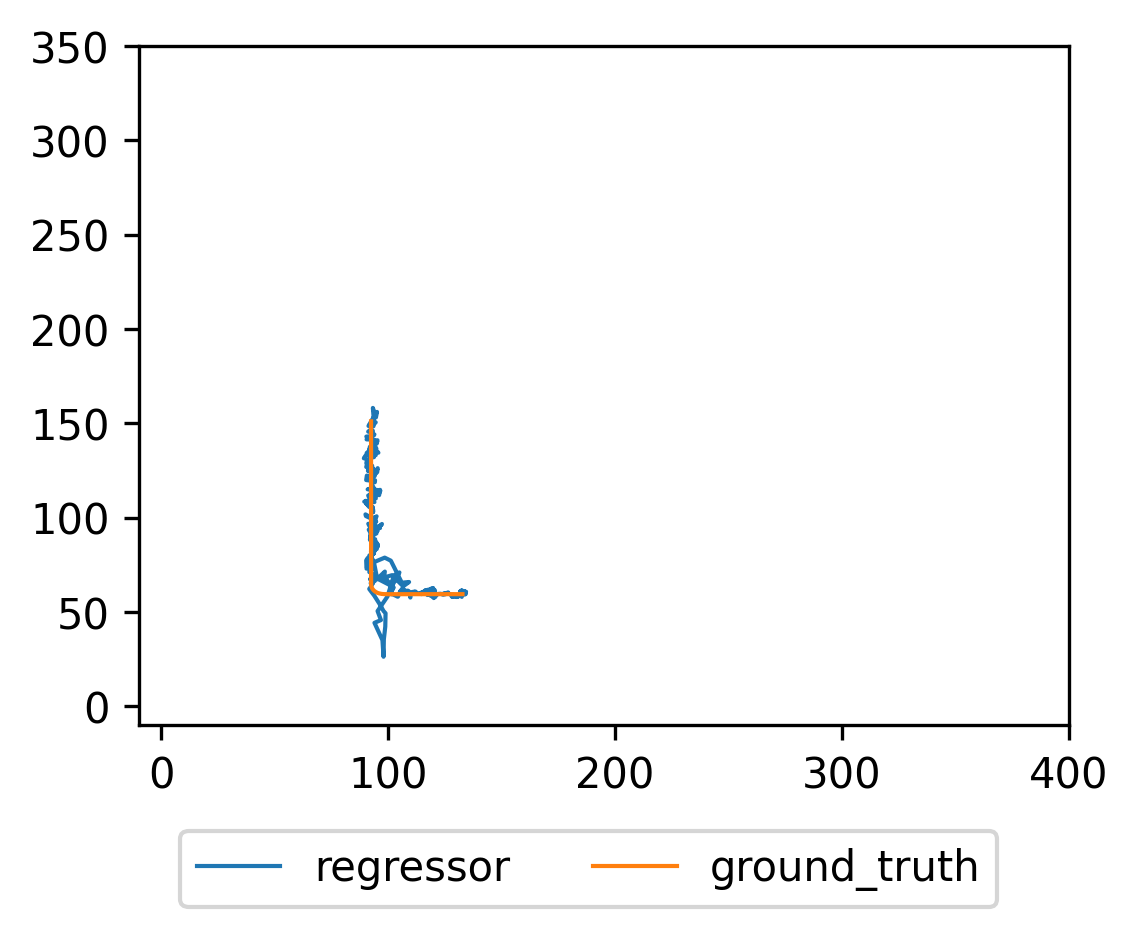

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_443.pt


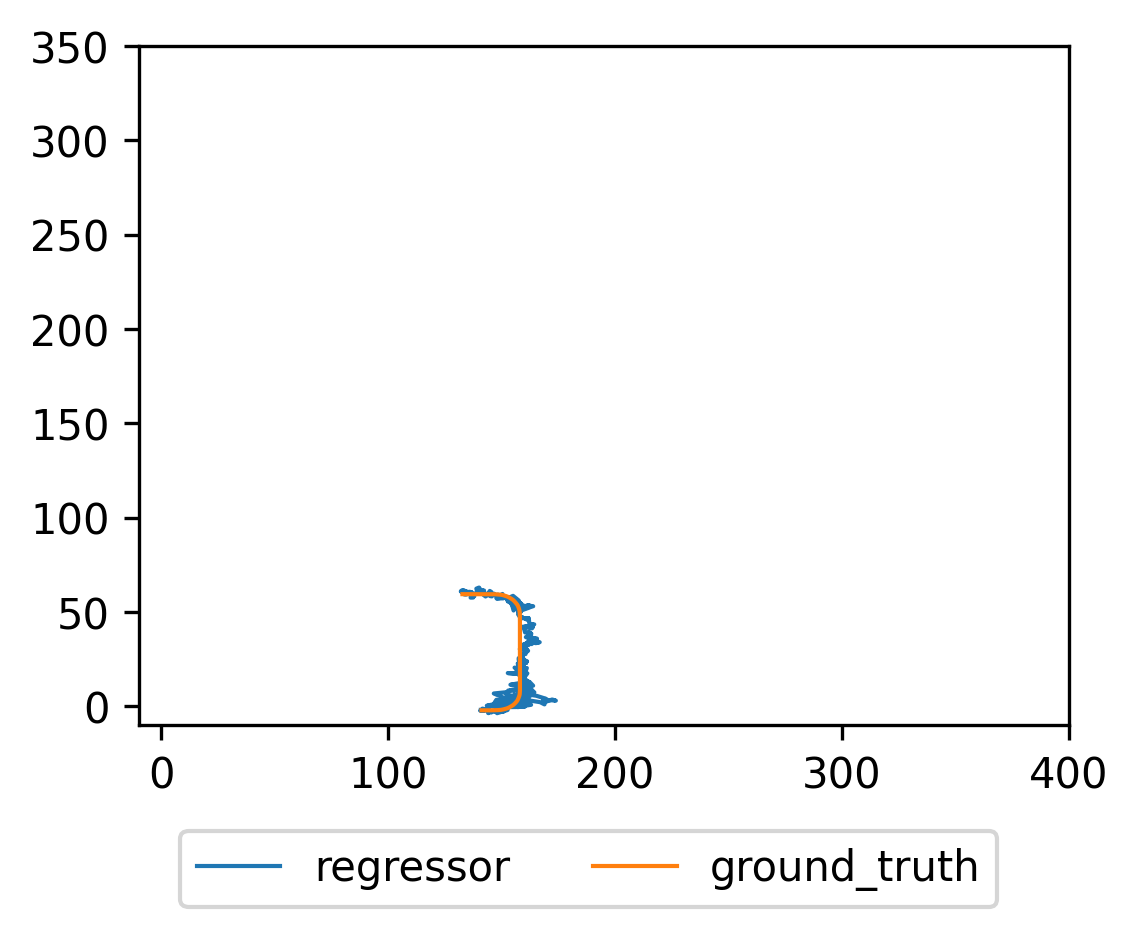

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_444.pt


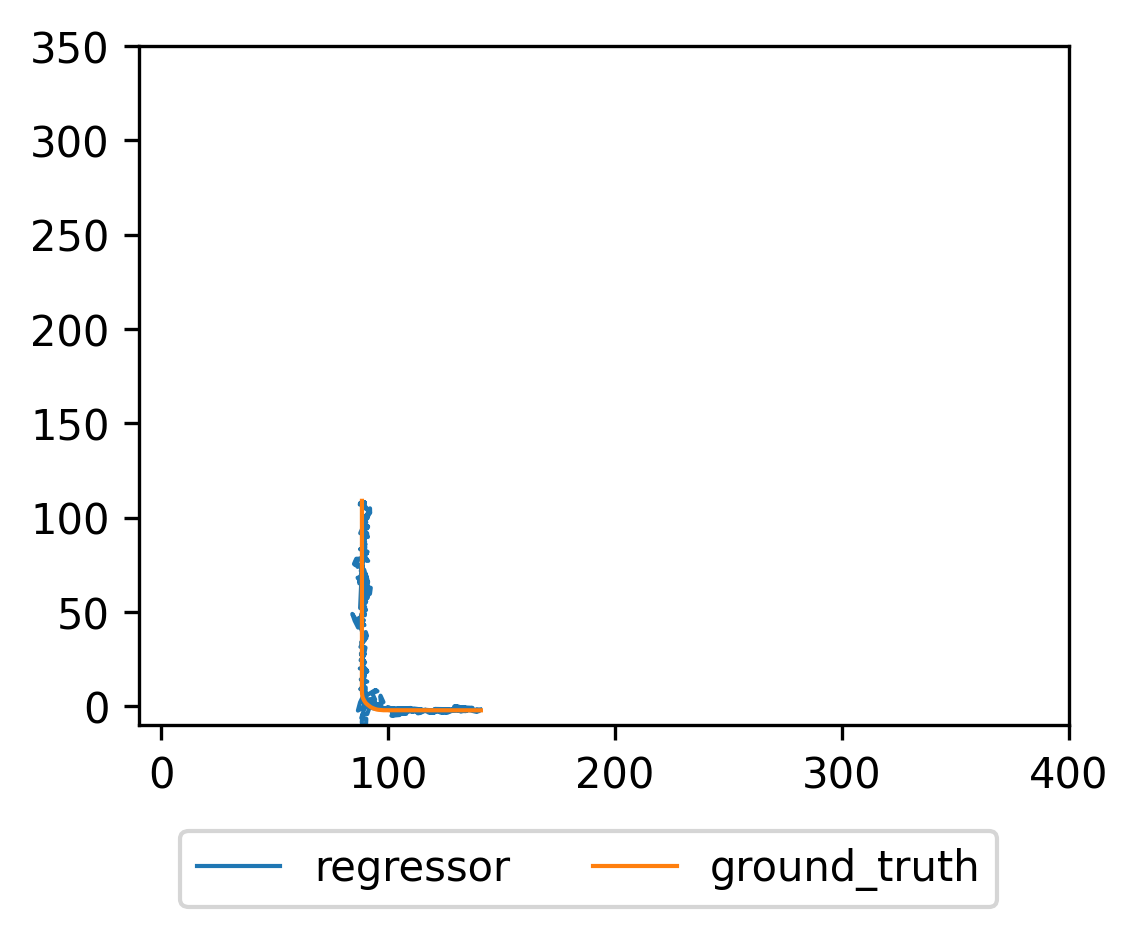

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_445.pt


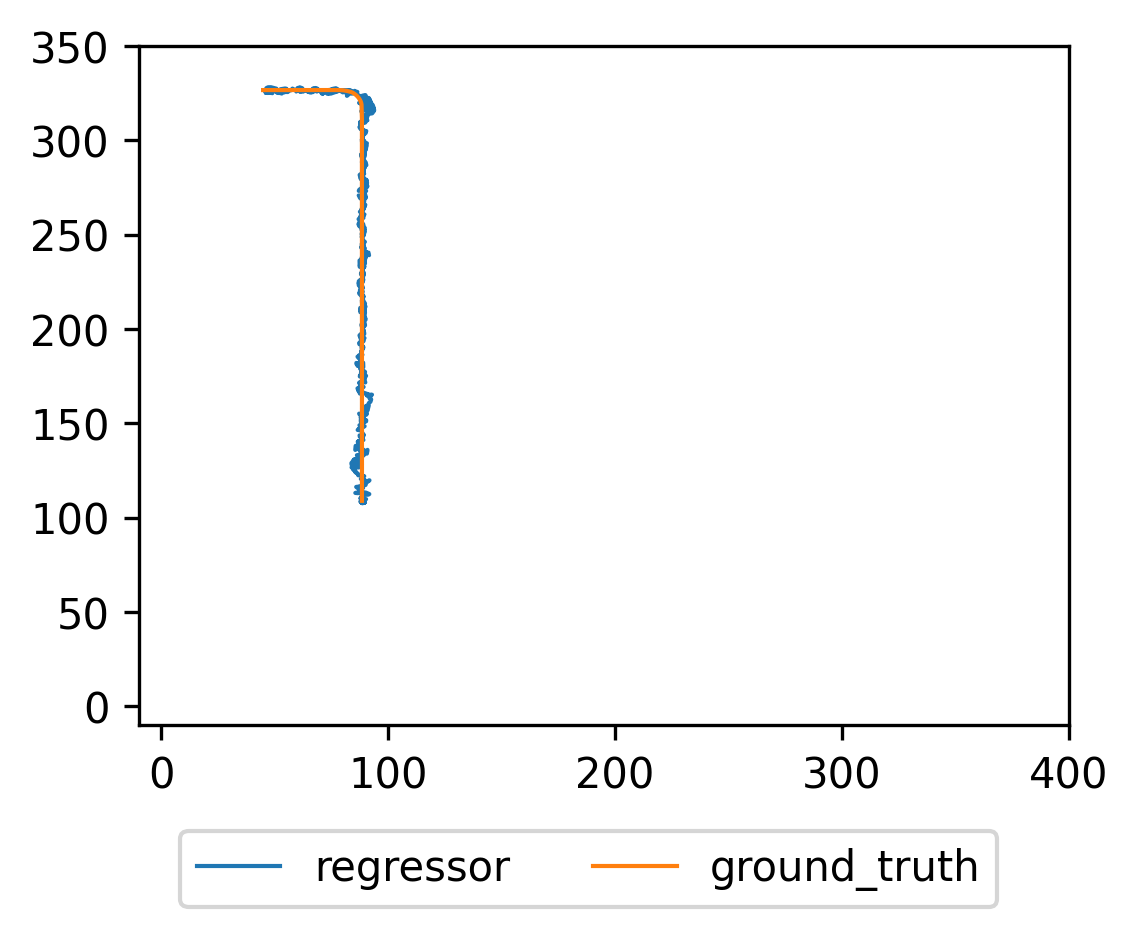

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_446.pt


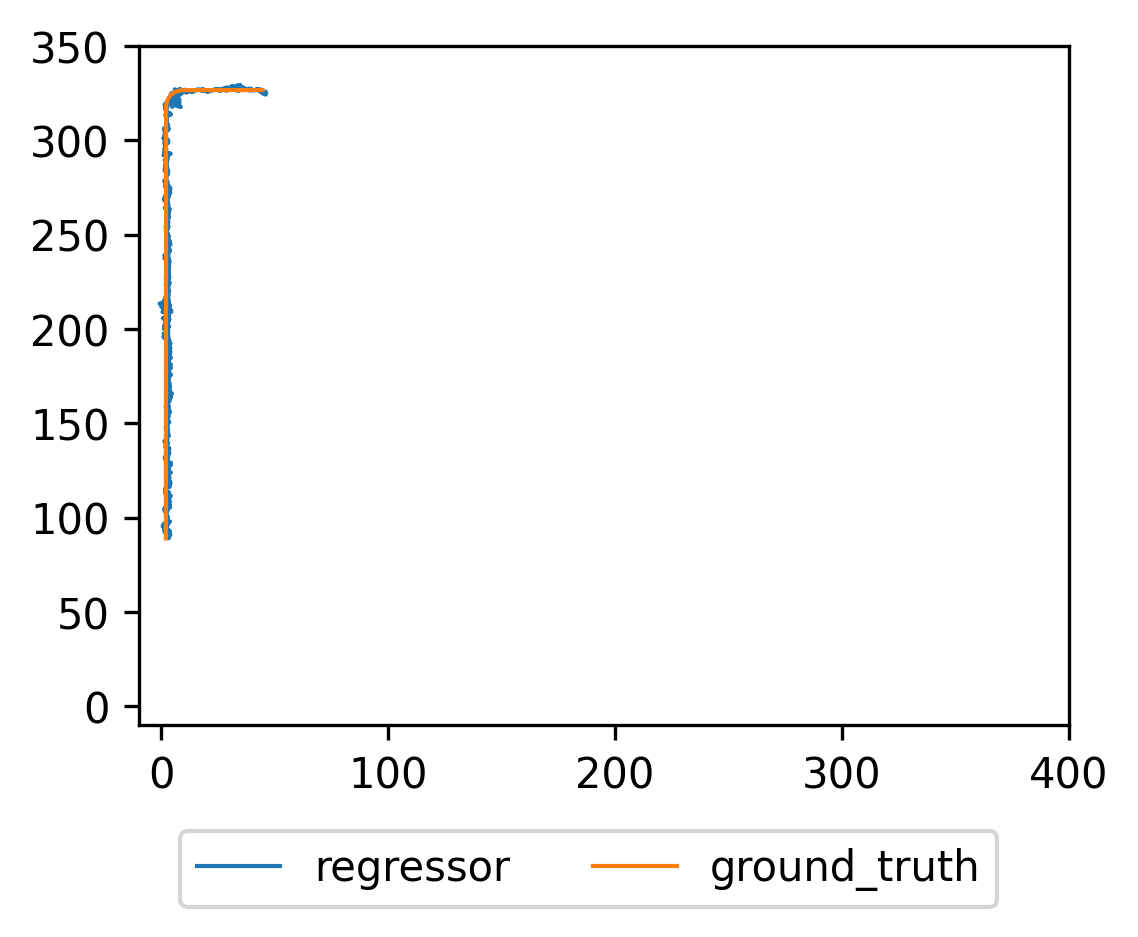

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_447.pt


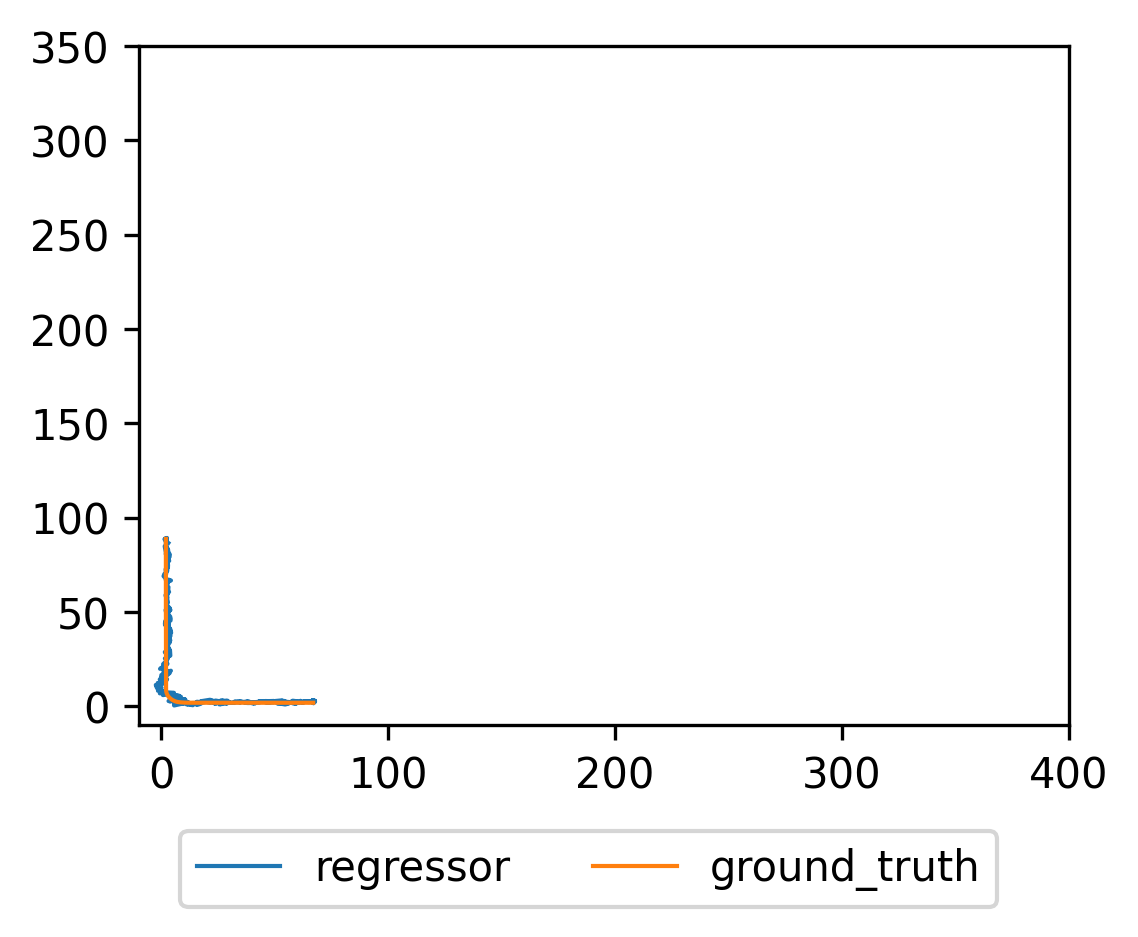

In [116]:
for i in range(20):
    path = df.iloc[i,0]
    out, gt = predict_trajectory(path)
    k = path.split('/')[-1]
    plot_trajectory(out, gt, k)